<a href="https://colab.research.google.com/github/Alfred024/CNN_model_training/blob/main/cnn-tipo-cultivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomprossed .rar files that contains png´s, please
import os

rar_file = 'Black-grass.rar'
extract_path = '/content'
os.makedirs(extract_path, exist_ok=True)
!unrar x {rar_file} {extract_path}


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Unexpected end of archive

Extracting from Black-grass.rar


Would you like to replace the existing file /content/Black-grass/1.png
 29128 bytes, modified on 2019-10-15 13:36
with a new one
 29128 bytes, modified on 2019-10-15 13:36

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/Black-grass/1.png                                     0%  OK 
Extracting  /content/Black-grass/10.png                                    0%  OK 
Extracting  /content/Black-grass/100.png                                   0%  OK 
Extracting  /content/Black-grass/101.png                                   0%  OK 
Extracting  /content/Black-grass/102.png                                   0%  OK 
Extracting  /content/Black-grass/103.png                                   0%  OK 
Extracting  /content/Black-grass/104.png                                   0%  OK

In [ ]:
!mkdir Imagenes
!mv ./Black-grass ./Imagenes
!mv ./Charlock ./Imagenes
!mv ./Common\ Chickweed ./Imagenes

In [ ]:
# LIBRARIES IMPORTATION

import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
# DATA LOADING

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Imagenes",
    seed=123,
    shuffle = True,
    image_size= IMAGE_SIZE,
    batch_size= BATCH_SIZE # batches are like a group of various images
)

# Result = 65 batches
class_names = dataset.class_names
class_names

Found 677 files belonging to 3 classes.


['Black-grass', 'Charlock', 'Common Chickweed']

In [ ]:
# SPLIT OF DATA

def get_splitDataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(val_size)
    testing_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, validation_dataset, testing_dataset

train_dataset, validation_dataset, testing_dataset = get_splitDataset(dataset)

In [ ]:
# PREFETCHING + CACHING IMAGE
# (In this case, cache would help storing
# image data to do the processing of next epoch faster)

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify datasets are not empty
train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in testing_dataset)
validation_count = sum(1 for _ in validation_dataset)

print(f'Train dataset size: {train_count}')
print(f'Testing dataset size: {test_count}')
print(f'Validation dataset size: {validation_count}')

Train dataset size: 17
Testing dataset size: 3
Validation dataset size: 2


In [ ]:
# DATA AUGMENTATION
# To make our modelo more robust

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]), # Removed 'experimental'
    tf.keras.layers.Rescaling(1.0/255) # Removed 'experimental'
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'), # Removed 'experimental'
    tf.keras.layers.RandomRotation(0.2) # Removed 'experimental'
])

print(f'Train dataset size: {train_count}')
print(f'Testing dataset size: {test_count}')
print(f'Validation dataset size: {validation_count}')

Train dataset size: 17
Testing dataset size: 3
Validation dataset size: 2


In [ ]:
# MODEL TRAINING

input_shape = IMAGE_SIZE + (CHANNELS,)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build(input_shape=input_shape)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    # batch_size=BATCH_SIZE,
    validation_data=train_dataset,
    verbose=1,
    epochs=EPOCHS,
)

# To see the accuracy of the trained dataset
# scores = model.evaluate(testing_dataset)
# scores

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 624ms/step - accuracy: 0.6847 - loss: 1.0034 - val_accuracy: 0.6750 - val_loss: 0.8682
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6714 - loss: 0.8711 - val_accuracy: 0.6750 - val_loss: 0.8391
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6641 - loss: 0.8340 - val_accuracy: 0.6750 - val_loss: 0.7438
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6806 - loss: 0.6237 - val_accuracy: 0.6750 - val_loss: 0.4137
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7525 - loss: 0.4075 - val_accuracy: 0.8317 - val_loss: 0.2941
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8319 - loss: 0.3019 - val_accuracy: 0.8298 - val_loss: 0.2809
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8709 - loss: 0.2315 - val_accuracy: 0.8395 - val_loss: 0.2243
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8240 - loss: 0.2583 - val_accuracy: 0.8395 - val_loss: 

first image to predict
actual label: Charlock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
predicted label: Charlock


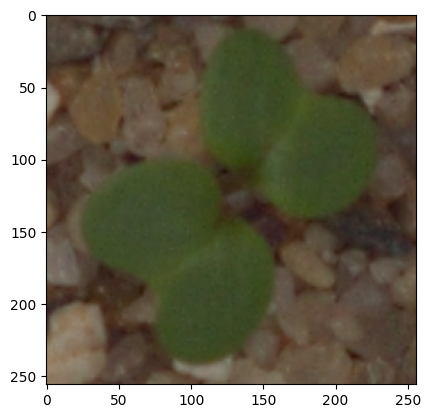

In [ ]:
# IMPLEMENTATION OF MODEL ON SAMPLE IMAGE

import numpy as np
for images_batch, labels_batch in testing_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Imágen numpeada: [[[ 90.4021    72.20105   45.472412]
  [ 93.241394  73.10077   46.945312]
  [ 90.88025   69.90112   42.57428 ]
  ...
  [114.11066  103.36719   84.69403 ]
  [114.900024 102.30707   83.30707 ]
  [114.995056 101.13074   83.859375]]

 [[ 90.974976  71.56793   47.934326]
  [ 91.0343    71.65692   46.912354]
  [ 89.30841   68.67944   42.449036]
  ...
  [111.35181   98.855774  79.64484 ]
  [113.578125 100.53363   81.32269 ]
  [114.92969  101.71875   82.50781 ]]

 [[ 80.78229   57.817383  34.861572]
  [ 87.40973   66.50336   44.792297]
  [ 89.57953   69.1236    46.82672 ]
  ...
  [108.25641   92.85016   72.375   ]
  [112.57837   97.80109   77.449524]
  [115.20709  100.50397   80.47925 ]]

 ...

 [[ 98.64844   71.07031   51.115906]
  [ 98.21503   71.70337   52.14087 ]
  [ 96.38501   70.03345   49.80548 ]
  ...
  [ 94.213745  76.86218   53.09015 ]
  [ 90.89075   72.238464  48.51587 ]
  [ 90.73309   70.803406  48.6875  ]]

 [[ 99.11096   70.44769   50.462524]
  [100.0343    73.24

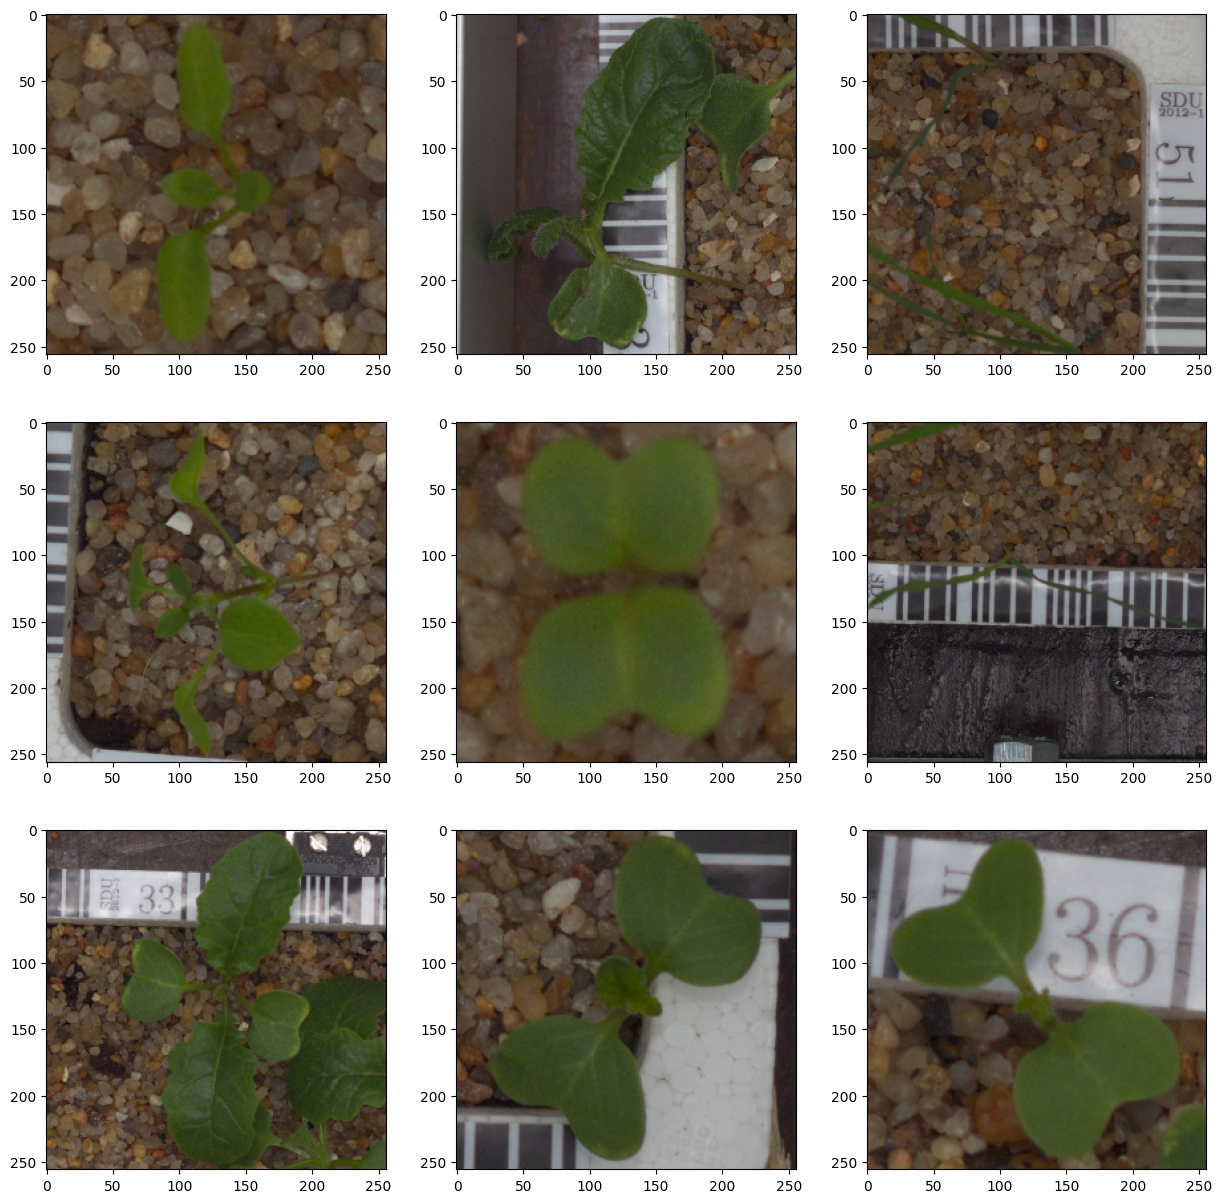

In [ ]:
# IGNORAR ESTE CÓDIGO
# FUNCTION TO PREDICT BASED ON A IMAGE

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in testing_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save('model_V4.h5')
from google.colab import files
files.download('model_V4.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# DEPLOY CODE - DEMO (SUCCESS)
model = tf.keras.models.load_model("./model_V2.h5")

image_path = "./test_img.png"
image = tf.keras.preprocessing.image.load_img(image_path)
img_array = tf.keras.preprocessing.image.img_to_array(image)

img_array_expand = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array_expand)

print("Predictions:",predictions)

predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)

print(f"class {predicted_class}, confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predictions: [[6.1273627e-04 9.9837995e-01 1.0073879e-03]]
class Charlock, confidence: 99.84


In [ ]:
!pip list | grep Pil


Pillow                           9.4.0
